In [1]:
import pandas as pd
import os
from scipy import stats
import numpy as np
%matplotlib inline
import seaborn as sb
import matplotlib.pyplot as plt
import dask.dataframe as dd
from datetime import datetime
import random
import sys

In [2]:
raw = '../data/raw/'

In [3]:
#train = pd.read_csv(raw + 'train.csv', skiprows = np.arange(1, 125497040 - 10000), header = 0)
dtrain = dd.read_csv(raw + 'train_2016.csv')
train = pd.read_csv(raw + 'train_2016_subset.csv')
items = pd.read_csv(raw + 'items.csv')
holidays = pd.read_csv(raw + 'holidays_events.csv')
oil = pd.read_csv(raw + 'oil.csv')
stores = pd.read_csv(raw + 'stores.csv')
transactions = pd.read_csv(raw + 'transactions.csv')

#train, items, stores, transactions, and oil can be merged straightforwardly, for holidays we need to worry about

In [4]:
#train.to_csv(raw + 'train_last_10k.csv', index = False)

In [5]:
len(train)

10000

In [6]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,66466622,2016-01-02,3,1464027,9.0,False
1,66470811,2016-01-02,5,1457337,8.0,False
2,66478896,2016-01-02,9,783243,20.0,False
3,66481246,2016-01-02,10,1239795,3.0,False
4,66484171,2016-01-02,12,519718,12.0,False


In [7]:
train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
9995,101678874,2016-12-31,49,1400332,1.0,False
9996,101679619,2016-12-31,49,1964738,7.0,False
9997,101681717,2016-12-31,50,1464038,3.0,False
9998,101685690,2016-12-31,53,872307,10.0,False
9999,101688777,2016-12-31,54,2048515,3.0,False


In [8]:
dtrain.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,66458907,2015-12-31,54,2027252,4.0,False
1,66458908,2016-01-01,25,105574,12.0,False
2,66458909,2016-01-01,25,105575,9.0,False
3,66458910,2016-01-01,25,105857,3.0,False
4,66458911,2016-01-01,25,108634,3.0,False


In [9]:
dtrain.loc[1]['date'].compute()

1    2016-01-01
1    2016-01-18
1    2016-02-04
1    2016-02-20
1    2016-03-08
1    2016-03-24
1    2016-04-10
1    2016-04-26
1    2016-05-12
1    2016-05-29
1    2016-06-14
1    2016-07-01
1    2016-07-17
1    2016-08-02
1    2016-08-18
1    2016-09-04
1    2016-09-20
1    2016-10-06
1    2016-10-22
1    2016-11-07
1    2016-11-23
1    2016-12-09
1    2016-12-23
Name: date, dtype: object

In [10]:
print('Train: ', train.columns, '\n\n Items: ', items.columns,
     '\n\n Holidays: ', holidays.columns, '\n\n Oil:', oil.columns, 
        '\n\n Stores: ', stores.columns,
     '\n\n Transactions: ', transactions.columns)

Train:  Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object') 

 Items:  Index(['item_nbr', 'family', 'class', 'perishable'], dtype='object') 

 Holidays:  Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object') 

 Oil: Index(['date', 'dcoilwtico'], dtype='object') 

 Stores:  Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object') 

 Transactions:  Index(['date', 'store_nbr', 'transactions'], dtype='object')


In [11]:
d = train.merge(items)
d = d.merge(oil)
d = d.merge(stores)
d = d.merge(transactions)

In [12]:
d.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,dcoilwtico,city,state,type,cluster,transactions
0,71278985,2016-02-22,6,1464027,3.0,False,BEVERAGES,1148,0,31.37,Quito,Pichincha,D,13,1630
1,82077989,2016-06-14,6,1913600,1.0,False,PERSONAL CARE,4118,0,48.49,Quito,Pichincha,D,13,1603
2,92852321,2016-10-04,6,881701,2.0,False,GROCERY I,1042,0,48.67,Quito,Pichincha,D,13,1605
3,72713582,2016-03-08,6,1150954,2.0,False,BEVERAGES,1124,0,36.67,Quito,Pichincha,D,13,1732
4,72714342,2016-03-08,6,1898960,5.0,False,BEVERAGES,1126,0,36.67,Quito,Pichincha,D,13,1732


In [13]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [14]:
pd.crosstab(holidays['locale'], holidays['locale_name'])

locale_name,Ambato,Cayambe,Cotopaxi,Cuenca,Ecuador,El Carmen,Esmeraldas,Guaranda,Guayaquil,Ibarra,...,Machala,Manta,Puyo,Quevedo,Quito,Riobamba,Salinas,Santa Elena,Santo Domingo,Santo Domingo de los Tsachilas
locale,,,,,,,,,,,,,,,,,,,,,
Local,12,6,0,7,0,6,6,12,11,7,...,6,6,6,6,13,12,6,0,6,0
National,0,0,0,0,174,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Regional,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,6


In [15]:
stores.city.unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'], dtype=object)

In [16]:
stores.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [17]:
#okay, so local means city, regional means state, and national means 'everywhere'
d['holitype'] = 'No_Holiday'
nat_n = 0
reg_n = 0
loc_n = 0
for i in range(0, len(d['holitype']) -1):
    if d['date'][i] in holidays['date'].values:
        this_day = holidays[holidays.date == d['date'][i]]
        if 'National' in this_day['locale'].values:
            #d['holitype'][i] = this_day['type']
            #print(this_day[this_day.locale == 'National'])
            #print('National')
            nat_n += 1
        elif 'Regional' in this_day['locale'].values:
            #print('Regional')
            reg_n += 1
        elif 'Local' in this_day['locale'].values:
            #print('Local')
            loc_n +=1
print('National: ', nat_n)
print('Regional: ', reg_n)
print('Local: ', loc_n)
# this is gonna take way too long for my little baby laptop, hmm

National:  998
Regional:  55
Local:  430


In [18]:
#d['date'][0]
#guess that makes sense since we are starting in August, eek! Lets get all of a year at least!

In [19]:
#dates_only = pd.read_csv(raw + 'train.csv', usecols = ['date'])

In [20]:
#dates_2016 = dates_only[['2016' in x for x in dates_only.date]].index
#print('First: ', dates_2016[0])

In [21]:
#skip = list(range(1, dates_2016[0]))

In [22]:
#skip += (list(range(dates_2016[-1] + 1, 125497041)))

In [23]:
#skip2 = [x for x in skip if type(x) == int ]

In [24]:
#train_2016 = pd.read_csv(raw + 'train.csv', skiprows = skip2)

In [25]:
#train_2016.to_csv(raw + 'train_2016.csv', index = False)

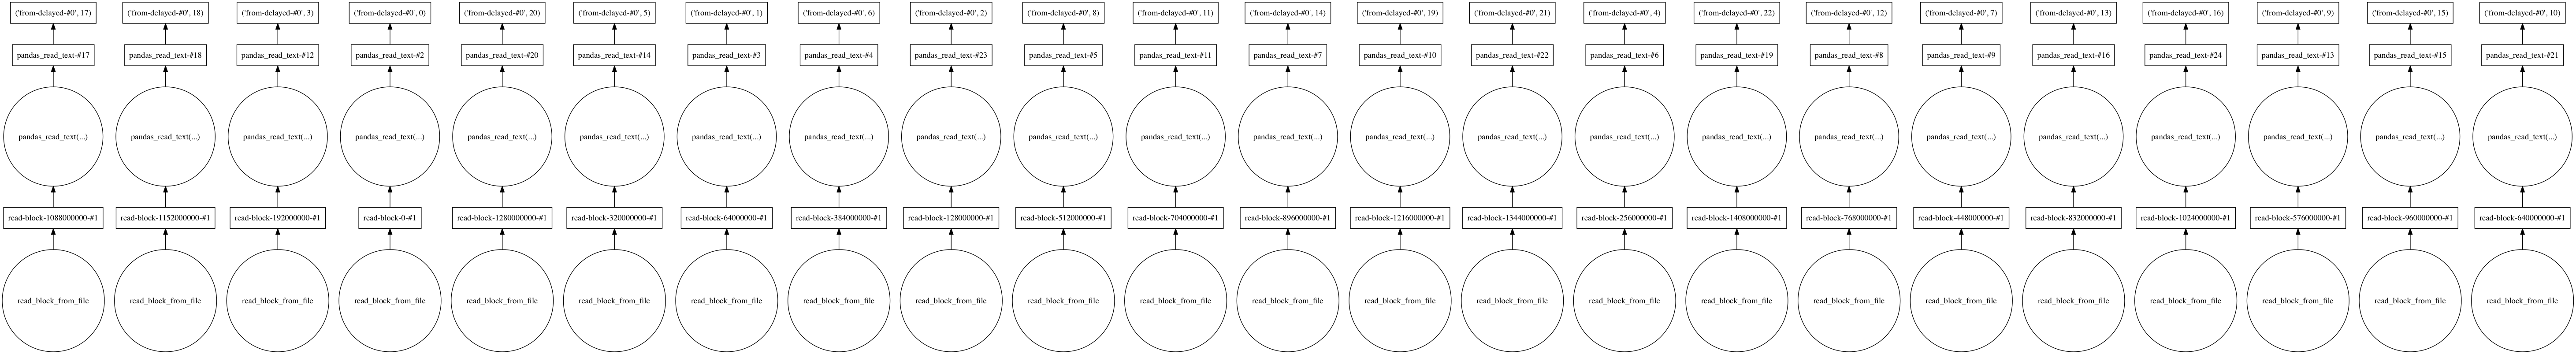

In [26]:
dtrain.visualize()

In [27]:
len(d[d.date == '2016-01-05'])

20

In [28]:
len(train)

10000

In [29]:
#n = 35229871
#s = 10000
#skip3 = sorted(random.sample(range(1,n),n-s))
#train2 = pd.read_csv(raw + 'train_2016.csv', skiprows = skip3)
#train2.to_csv(raw + 'train_2016_subset.csv', index = False)